# Dset Description

INPUT COLUMNS:

- *PassengerId* - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- *HomePlanet* - The planet the passenger departed from, typically their planet of permanent residence.
- *CryoSleep* - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- *Cabin* - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- *Destination* - The planet the passenger will be DEBARKING to.
- *Age* - The age of the passenger.
- *VIP* - Whether the passenger has paid for special VIP service during the voyage.
- *RoomService, FoodCourt, ShoppingMall, Spa, VRDeck* - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- *Name* - The first and last names of the passenger.

OUTPUT (TARGET) COLUMN:
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import copy
#Libraries for data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Machine Learning models
from sklearn.linear_model import LogisticRegression, LinearRegression
# Libraries for model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import cross_val_score

In [2]:
# Modify the cell size in Jupyter
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_dataset (download_from_kaggle, destination_folder, source_path=None ):
    """
    :purpose: Download the dataset directly from Kaggle, after inserting username and password, or input own path
    :param: download_from_kaggle: Boolean: option to download the dset from Kaggle or not
    :param: destination_folder: where to save the unzipped csv's
    :source_path: path where to access the dataset in the laptop in case the download_from_kaggle option is set to False
    :output: train and test datasets in format: pd.DataFrame
    """

    
    if download_from_kaggle:
        
        import opendatasets as od
        
        path = "https://www.kaggle.com/competitions/spaceship-titanic/data"
        od.download(path)
        #{"username":<KAGGLE USERNAME>,"key":"<KAGGLE KEY>"}
 
    with zipfile.ZipFile(source_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

    train = pd.read_csv('train.csv', sep=',')
    test = pd.read_csv('test.csv', sep=',')
    
    return train, test


In [4]:
def get_stats ( data ):

    """Plot the share of num values per each column
    :param: data: pd.DataFrame to analyse
    :output: 
        - stacked horizontal bar chart of nulls vs non-nulls
        - stats summary
    """
    graph = plt.figure(figsize=(20,6))
    sns.displot(
        data=data.isna().melt(value_name="missing"),
        y="variable",
        hue="missing",
        multiple="fill",
        aspect=1 )
    stats = data.info()
    
    return graph, stats
    

# Functions

In [5]:
def cryoNull (df):
    
    """
    :purpose: fill the Nulls in the Cryo column
    :param: df: pd.DataFrame, the original train df
    :output: the df with cryo values filled
    """
    
    cryo = "CryoSleep"
    cryodf = copy.deepcopy(df)
    # We isolate the nulls
    cryodf = cryodf[cryodf[cryo].isna()]

    # Graphs showed that cryo highly negatively correlates with expenses, so we build the expenses column
    cryodf ['Expenses'] = cryodf [['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

    # Let's remove the cases of Expenses being themselves a Null
    cryoExdf = copy.deepcopy(cryodf)
    cryoExdf = cryoExdf[~cryoExdf["Expenses"].isna()]

    # Let's use Expenses to input cryo (i.e. if the passenger had expenses, surely it wasn't cryopreserved)
    cryoExdf[cryo] = np.where(cryoExdf['Expenses']>0, False, cryoExdf[cryo] )

     # print("null values for {} after expenses: {}".format(cryo, cryoExdf[cryoExdf[cryo].isna()].shape[0])) # Output: 98

    """
    For the remaining, we check the share of preserved ppl with no expenses instead
    """
    # Initial df with no nulls in cryo
    share = df [~df [cryo].isna()]

    # Out of the ones with no expenses, how many were cryopreserved?
    share ['Expenses'] = share [['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    share = share[~share["Expenses"].isna()] # we eliminate where we don't know expenses

    # How many with no expenses were NOT cryopreserved? 
    cond = share[(share[cryo]==False)&(share['Expenses']==0)].shape[0]
    NoCryoNoExp = cond /share.shape[0] # Output: 0.0611 ==> 6.1%
    
    """Since the percentage of non-cryopreserved and with no expenditure is around 6%, that would mean 
    recording as non-cryospeepers only 6 people out of the remaining missing ones, adding very little to the model's precision.
    After all, it is more likely there were none . So, I'll replace the remaining as cryo=False
    """
    cryoExdf[cryo] = np.where(cryoExdf['Expenses']>0, False, True )
    del cryoExdf['Expenses']
    
    # Now we need to join this with the original df
    df = df.merge(cryoExdf, how='left', on=[c for c in df.columns if c!=cryo], suffixes=(["","_fixed"]) )
    
    # Now we replace the cryo column
    df[cryo] = df[cryo].fillna(df["{}_fixed".format(cryo)])
    del df ["{}_fixed".format(cryo)]
    
    return df


In [6]:
"""NEXT STEPS: Add null column management / fill option!"""
def data_preparation (df, dropna=True):
    
    # Let's fill the cryosleep column
    df = cryoNull (df)
    
    if dropna:

        df = df.dropna()
    else:
        print("add methods to fill nulls")
        
    return df

In [7]:
def categorical_cols_plot (train, plt_col, target_col = 'Transported', count_col = 'PassengerId'):
    
    """ 
    :purpose: plot the categorical values shares over the total and by the output column
    :param: df: pd.DataFrame
    :param: plt_col: categorical columns for which we want to produce the plots
    """

    for col in plt_col:

        # Share for each category on the total
        p = train.groupby([col])[count_col].count().transform(lambda x: x/x.sum())
        # Share for each category on Transported = True
        df = train[train[target_col]==True]
        pt = df.groupby([col])[count_col].count().transform(lambda x: x/x.sum())
        # Share for each category on Transported = False
        fdf = train[train[target_col]==False]
        pnt = fdf.groupby([col])[count_col].count().transform(lambda x: x/x.sum())

        plt.figure(figsize=(15, 15))
        plt.subplot(1,3,1)
        plt.pie(p, labels = p.index, autopct='%1.2f%%') 
        plt.title ("{}, Total".format(p.index.name))

        plt.subplot(1,3,2)
        plt.pie(pt, labels = pt.index,autopct='%1.2f%%')
        plt.title ("{} /{}".format(p.index.name, target_col) )

        plt.subplot(1,3,3)
        plt.pie(pnt, labels = pnt.index,autopct='%1.2f%%')
        plt.title ("{} /Not {}".format(p.index.name, target_col) )

        plt.show()



In [8]:
def distribution_plot (cont_col,train):
    """
    :purpose: Plot the distribution of continuous variables by target column to spot any difference
    :param: cont_col: list of columns with continuous values
    :param: train: pd.DataFrame
    :output: return histogram
    """

    for c in cont_col:

        train.hist(column= c,by=tgtCol,sharey=True,sharex=True, density=True,figsize=(15,5))
        plt.suptitle('{} Distribution grouped by {}'.format(c, tgtCol))
    
        """Explore to add totals on bars using plt.annotate or bar_label. None worked here."""
        
        plt.show()


In [9]:
def remove_outliers (lst, train):
    
    """
    :purpose: Use IQR to detect outliers and replace them with their respective max possible values (within distribution)
    :param: lst: list of continuous values columns with outliers
    :param: train: pd.DataFrame
    :output: train dset with fixed outliers
    """

    for c in lst:

        # Calculate the first and third quartile (Q1 and Q3). NB: We filter for data > 0 to make sure we capture the outliers below Q1 
        Q1 = np.float(train[train[c]>0][c].quantile([0.25]))
        Q3 = np.float(train[train[c]>0][c].quantile([0.75])) 

        # Evaluate the interquartile range, IQR = Q3-Q1
        IQR = np.float(train[train[c]>0][c].quantile([0.75])) - np.float(train[train[c]>0][c].quantile([0.25]))

        # Estimate the lower bound = Q1*1.5, and the upper bound = Q3*1.5 outside of which any data is consider an outlier
        lb = Q1*1.5
        hb = Q3*1.5

        # Replace the data points that lie outside of the lower and the upper bound with the lower/upper bound respectively.
        train [c]= np.where((train[c] < lb) & (train[c] != 0), lb, train[c]) # NB we replace only values >0!
        train [c] = np.where ((train[c] > hb)& (train[c] != 0), hb, train[c])
    
    return train

In [10]:
def scale_cont_vars (cont_col, df):
    """
    :purpose: scale continuous variables
    :param: cont_col: list of columns with continuous values that we want to scale
    :param: df : pd.DataFrame
    :output: initial df with scaled columns
    """

    features = df[cont_col]
    

    # We account for the cases where we scale one column only
    if len(cont_col) ==1:

        features = np.array(features).reshape(-1, 1)
        scaler = StandardScaler().fit(features)
        features = scaler.transform(features)
        
    else:
        scaler = StandardScaler().fit(features.values)
        features = scaler.transform(features.values)

    # Now we put them back in the df
    df[cont_col] = features
    
    return df


In [11]:
def encode_categorical_cols (df, cats):
    """
    :purpose: encode categorical variables
    :param: df: pd.DataFrame
    :param: cats: list of categorical columns we want to encode
    :output: df with encoded categorical columns
    """

    features = df [cats]
    features = features.apply(LabelEncoder().fit_transform)
    df [cats] = features
    
    return df

#### Survived-Age Statistical Chi-Square Test

We will conduct a statistical chi-squared test to establish whether the Survived and Age variables are related.

Dependent Variable: Survived

Independent Variable: Age

$ O_{i}:$ the observed value of survived for the given age 

$ E_{i}:$ the expected value of survived for the given age

We will test the following hypotheses:

$ H_{0}:$ The Null Hypothesis, that there is no relationship between the Survived and Age variables (independent) $→ O_{i} ≠ E_{i} $

$ H_{A}: $ The Alternative Hypothesis, that there is a relationship between the Survived and Age variables (dependent) $→ O_{i} =E_{i}$

In [12]:
def fe_age_col (df):
    
    """
    :purpose: Bucket Age into Age groups if the X-Square test confirms the causality with the target column
    :param: non_scaled_df: pd.DataFrame where the input column (Age) isn't scaled yet
    :output: no change if X-square test is negative (no interdependency), or age bucket column added
    """
    
    # We bucket the data 
    interval = list(np.arange(0,df['Age'].max(),10))
    interval2 = interval+[df['Age'].max()+10]
    
    # We build the labels recursively
    lab = ["{}-{}".format(int(interval2[i]), int((interval2[i+1]-1))) for i in range(len(interval))]
    
    age_group_values = pd.cut( x= df['Age'], bins = interval, right = True, labels = lab[:-1])
    
    # We add the column in our dataframe
    df['Age Buckets'] = age_group_values
        
    #Make an observed-table for chi-squared test
    obs_table = pd.crosstab([df[tgtCol]],[df['Age Buckets']])
    
    #Compute Chi-square statistic
    from scipy.stats import chi2_contingency
    chi2, p, dof, expected = chi2_contingency(obs_table)

    ## report results
    # print('chi2:{}\ndof:{}\np:{}'.format(chi2,dof,p))
    if p < 0.05:
        
        # p is smaller than 0.05 and we therefore reject the Null-Hypothesis and accept that Survived and Age are dependent variables
        return df
    else:
        # p is bigger than 0.05 and we therefore accept the Null-Hypothesis and accept that Survived and Age are NOT dependent variables
        del df['Age Buckets']
        
        return df


In [13]:
def fe_expenses_col (df,expenses, delete = True):
    
    """
    COL ==> Expenses: 
    :purpose: Reduce Dimensionality: build a common, discretionary expenses column out of the various expenses ones and delete the others. Scale it.
    :param: df: pd.DataFrame
    :param: expenses: list of columns recording expenses
    :output: df with a single, scaled, column for expenses
    """

    df ['Expenses'] =  df[expenses].sum(axis=1)
    
    if delete:

        for ex in expenses:
            del df [ex]

    # Let's rescale the new column for safety although it is the sum of scaled columns
    df = scale_cont_vars (cont_col=['Expenses'], df=df)
    return df



In [14]:
def fe_cabin_col (df):
    
    """
    :purpose: the Cabin column takes the form deck/num/side, where side can be either P for Port or S for Starboard.
            We want to build a different feature where we account for the rough position (deck + side) within the spacecraft.
    :param: df: pd.DataFrame
    :output: a new, encoded, column combining the deck and side coordinates
    """
    
    # Let's split the cabin code into its components
    df ['Deck'] = df['Cabin'].apply(lambda x: x.split("/")[0]) # Char
    df ['Cab_Num'] = df['Cabin'].apply(lambda x: x.split("/")[1]) # Numerical
    df ['Side'] = df['Cabin'].apply(lambda x: x.split("/")[2]) # Char


    #We create a new column with the coordinates (Deck, Side) of the cabins
    df['Deck_Side'] = df ['Deck'] + df ['Side']
    
    # We encode the categorical values
    df = encode_categorical_cols (df=df, cats=["Deck", "Side", "Deck_Side"])
    
    return df

In [15]:
def family_col (df):
    
    """
    :purpose: "PassengerId" takes the form gggg_pp where:
              ==> gggg indicates a group the passenger is travelling with 
              ==> pp is their number within the group. 
              ==> People in a group are often family members, but not always.
                    ==> Let's check if the passenger was part of a group or not.
    :param: df: pd.DataFrame
    :output: new columns with family vs solo traveller and n.of components in family
    """
    df['psg_grp'] = df['PassengerId'].apply(lambda x: x.split("_")[0])
    # We count how many members for each group
    df['Family_no'] = df.groupby("psg_grp")['PassengerId'].transform(lambda x: x.count())
    
    # We manually encode the family column
    df ['Family'] = np.where(df ["Family_no"] >1, 1,0)
    
    # We scale the family_no column
    df = scale_cont_vars (cont_col=['Family_no'] , df=df)
    
    return df


In [16]:
def model_MSE (y, y_pred):
    """
    :pupose: compute the Mean Squared Error of the prediction vs ground truth
    :param: y: np.array, the ground truth 
    :param: y_pred: np.array, the predicted values
    :output: the MSE
    """
    
    return np.square (np.sum (y-y_pred)).mean()



In [17]:

def get_metrics(model_name, y_test, y_predicted, model, X_train, y_train, print_results = True):  
    
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')  
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    MSE = model_MSE (y=y_test, y_pred = y_predicted)
    
    if print_results:
    
        print(f'Model {model_name}: accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, score = %.3f, MSE = %.3f'%(
            accuracy, precision, recall, f1,  scores.mean(), MSE))
    
    return accuracy, precision, recall, f1, scores.mean(), MSE


In [18]:
def apply_model (model_name, train, model, print_results=True):
    """
    :purpose: apply train/test split and then apply the chosen model to predict the target column
    :param: df: pd.DataFrame inclusinve of the columns we selected for the prediction and the target column
    :param: model: the ML model that we want ot use for predicting
    :output: np.array with the prediction of the model applied to the X_test dset
    """
    
    df = copy.deepcopy(train)
    target = df[tgtCol]
    
    del df[tgtCol]
    
    # If the df remains with only one column, we need to reshape it
    if df.shape[1] == 1:
        
        df = np.array(df).reshape(-1, 1)

    # Split dset into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        df, target, stratify=target, test_size=0.15, random_state=5)
    
    # Apply model to our train dset, Gradient Descent is applied by the model to learn
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)

    accuracy, precision, recall, f1, score, MSE = get_metrics(model_name, y_test.tolist(), y_predicted, model, X_train, y_train, print_results)
    
    return y_predicted, accuracy, precision, recall, f1, score , MSE

In [19]:
def find_best_model (df, ML_model ):
    """
    :purpose: Check the correlation of each column with the target column, then order them from the highest correaleted to the lowest.
              Then remove the columns recursively staeting from the lowest correlated and test the model on the df with those column.
              Pick the model with the best score ranking
    :param: df = pd.DataFrame
    :output: returns the prediction of the model with the highest score alongside all the stats
    """
    
    
    """Order columns from higher to lower correlation with target column"""
    # Find the correlation df and isolate the target column
    corr = pd.DataFrame(df.corr()[tgtCol])
    # Compute the absolute value of correlations and sort the df accordingly
    corr ['abs_corr'] = np.abs(corr['Transported'])

    corr = corr.sort_values(by=["abs_corr"],ascending=False)
    
    # We isolate the original df's column list, ordered by abssolute value of the correlation with the target column in descending order
    col_lst = [c for c in corr.index if c != tgtCol] # note we will add the tgtCol later but we don't want to risk to remove it during recursion

    """Run the model deleting recursively the column with the lowest correlation
    As correlation highlights the linear dependency and we apply a linear model, it makes sense proceeding this way
    """
    model = copy.deepcopy(df)
    scores = {}
    
    
    for c in range(len(col_lst)):

        model = model [col_lst+['Transported']]

        m_pred, m_accuracy, m_precision, m_recall, m_f1, m_score, m_MSE = apply_model (model_name = col_lst, train=model, 
                                                                                              model=ML_model, print_results=False)
        scores.update({m_score : model.columns})
        
        col_lst.pop()

        if len(col_lst) ==1:

            break
            
      # Now we pick the model with the highest score (first element in the sorted dictionary by key)

    best_model = sorted (scores.items(), key=lambda x: x[0], reverse=True) [0]
    
    # Now run the model again to get the prediction
    optimal_cols = list( best_model[1])
    optimal_df = df[optimal_cols] # we build the df with the optimal column set
    
    m_pred, m_accuracy, m_precision, m_recall, m_f1, m_score, m_MSE = apply_model (model_name = optimal_cols, train=optimal_df, 
                                                                                              model=ML_model, print_results=True)

    return  m_pred, m_accuracy, m_precision, m_recall, m_f1, m_score, m_MSE 


# Code

Initial data exploration:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
(<Figure size 1440x432 with 0 Axes>, None)


<Figure size 1440x432 with 0 Axes>

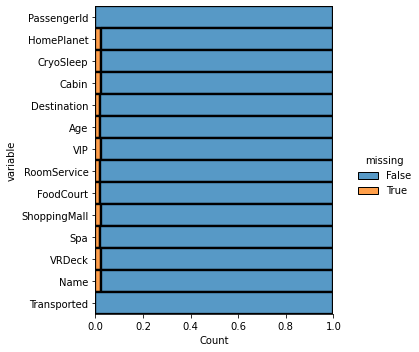

In [20]:
"""Import the dataset"""
source_path="C:/Users/scosso/Desktop/spaceship-titanic.zip"

train,test = get_dataset (download_from_kaggle = False, destination_folder = "Desktop", source_path=source_path)
# Alternatively, you can download the dataset from Kaggle - Warning: I was denied access so I couldn't test the code
# train,test = get_dataset (download_from_kaggle = True, destination_folder = "Desktop")

# We create a copy to preserve the original dataset
orig_train = copy.deepcopy(train)

# get_stats
print("Initial data exploration:")
print(get_stats ( data=train ))

# Variables
train = data_preparation (df=train, dropna=True)
tgtCol = 'Transported'

data exploration after dropping the null values:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6773 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6773 non-null   object 
 1   HomePlanet    6773 non-null   object 
 2   CryoSleep     6773 non-null   bool   
 3   Cabin         6773 non-null   object 
 4   Destination   6773 non-null   object 
 5   Age           6773 non-null   float64
 6   VIP           6773 non-null   object 
 7   RoomService   6773 non-null   float64
 8   FoodCourt     6773 non-null   float64
 9   ShoppingMall  6773 non-null   float64
 10  Spa           6773 non-null   float64
 11  VRDeck        6773 non-null   float64
 12  Name          6773 non-null   object 
 13  Transported   6773 non-null   bool   
dtypes: bool(2), float64(6), object(6)
memory usage: 701.1+ KB
(<Figure size 1440x432 with 0 Axes>, None)


<Figure size 1440x432 with 0 Axes>

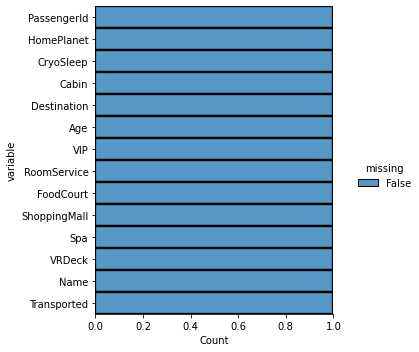

In [21]:
# QC
print("data exploration after dropping the null values:")
print(get_stats ( data=train ))
# train.head()

In [22]:
# Divide input columns between continuous and categoricals.
cont_col = train._get_numeric_data().columns.values.tolist()
cont_col.remove('Transported')
# Python considers booleans as numericals
cont_col.remove('CryoSleep')

cat_col = ['CryoSleep']+[c for c in train.columns if c not in cont_col and c not in ['Transported',"PassengerId", "Name"]]

print("Continuous input variables: {}; \nCategorical input variables: {}".format(cont_col, cat_col))

Continuous input variables: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']; 
Categorical input variables: ['CryoSleep', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']


In [23]:
train['CryoSleep'].unique()
train['CryoSleep'].dtype
train['VIP'].dtype

orig_train['CryoSleep'].unique()
# for c in cat_col:
#     print(c)
#     print(train[c].unique())

array([False, True, nan], dtype=object)

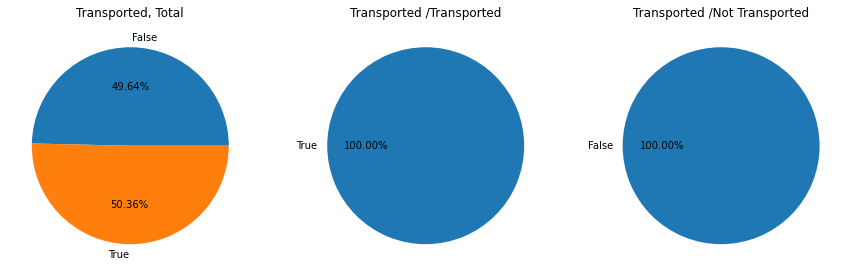

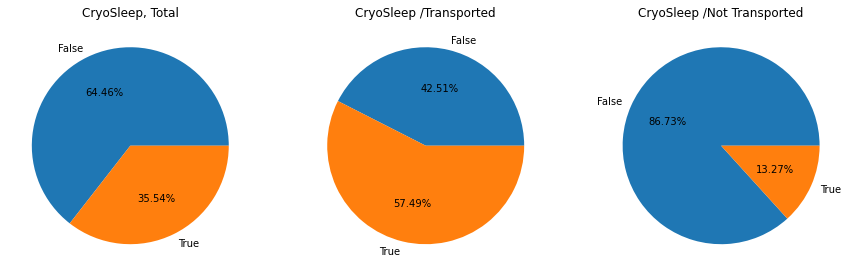

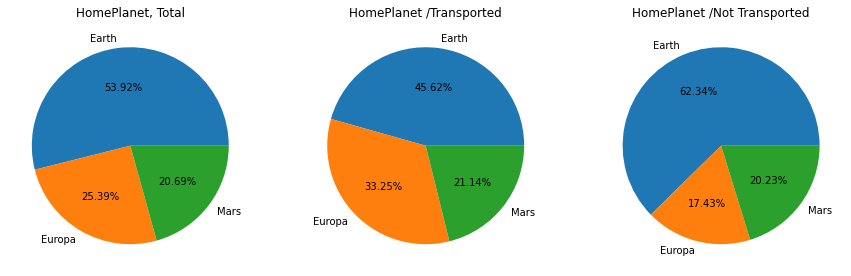

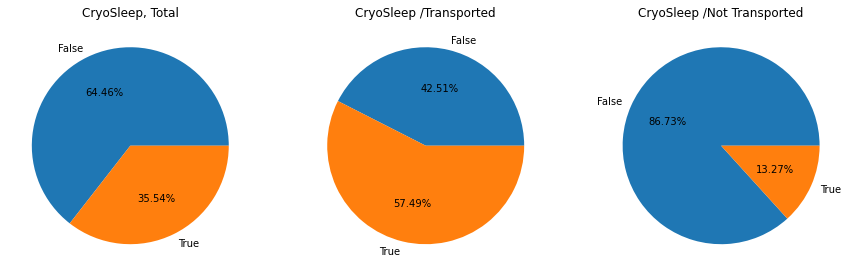

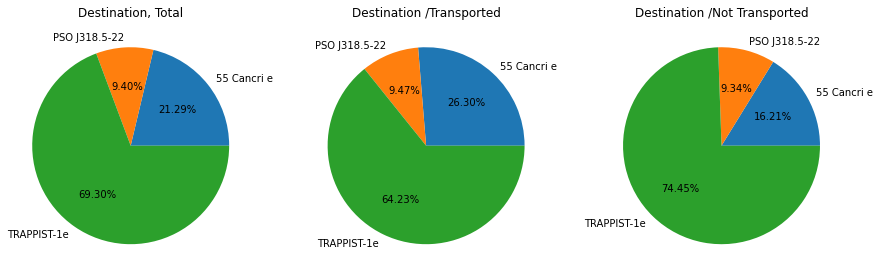

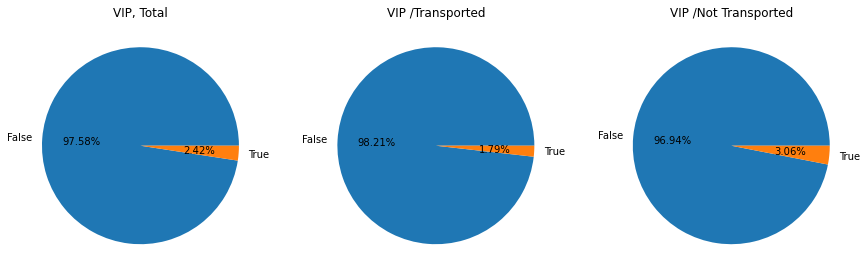

In [24]:
"""Let's plot the categorical columns by target column"""
categorical_cols_plot (train, plt_col = [tgtCol] + [c for c in cat_col if c != 'Cabin'])

Insight: 

- Cryosleep shows high correlation, 
- Home Planet and VIP might show mild correlation.
- Destination shows differences but might be down to Home Planet (you travel to a different planet compared to your own)

               Age  RoomService     FoodCourt  ShoppingMall           Spa  \
count  6773.000000  6773.000000   6773.000000   6773.000000   6773.000000   
mean     28.896648   222.695556    479.215119    177.472612    312.738078   
std      14.532565   648.087437   1675.056311    572.101744   1139.641201   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%      19.000000     0.000000      0.000000      0.000000      0.000000   
50%      27.000000     0.000000      0.000000      0.000000      0.000000   
75%      38.000000    48.000000     83.000000     29.000000     62.000000   
max      79.000000  9920.000000  29813.000000  12253.000000  22408.000000   

             VRDeck  
count   6773.000000  
mean     301.444116  
std     1120.660060  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       49.000000  
max    20336.000000  


<AxesSubplot:>

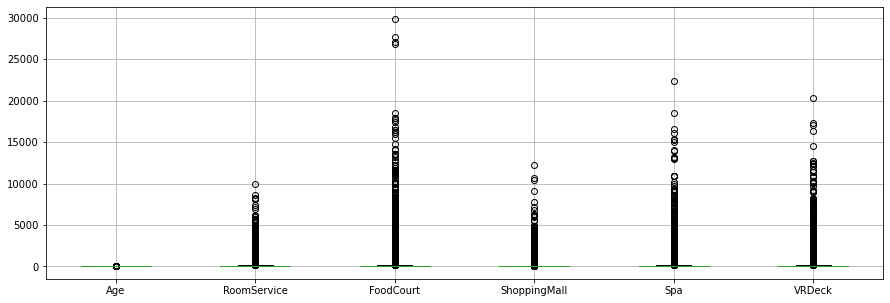

In [25]:
# Detect outliers:
print(train[cont_col].describe())
train.boxplot(cont_col,figsize=(15,5))

INSIGHT:
- We see outliers across the expenses columns, so we will replace them with the closest edge value (not outlier)

In [26]:
"""Remove outliers"""
# We remove age because from the boxplot we can see there are no outliers
lst = copy.deepcopy(cont_col)
lst.remove('Age')

train = remove_outliers (lst, train)
# QC
train[cont_col].describe() 

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000
mean,28.896648,166.231507,257.595157,130.681253,163.252288,161.294995
std,14.532565,349.685823,554.278480,286.633272,337.065590,344.312054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,57.000000,83.000000,33.000000,62.000000,49.000000
max,79.000000,1251.000000,1947.000000,1052.625000,1154.625000,1204.500000


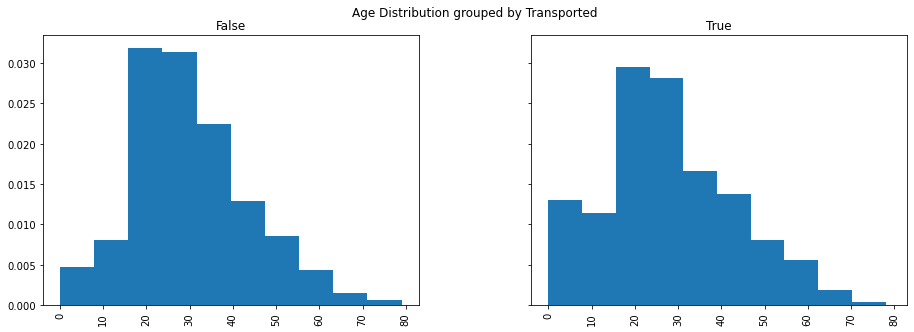

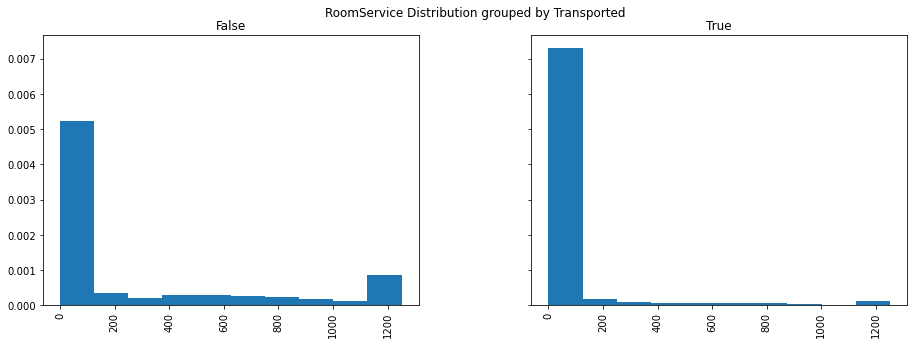

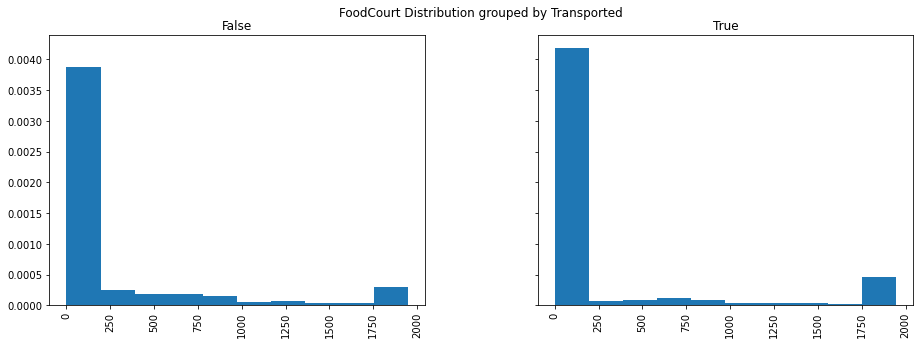

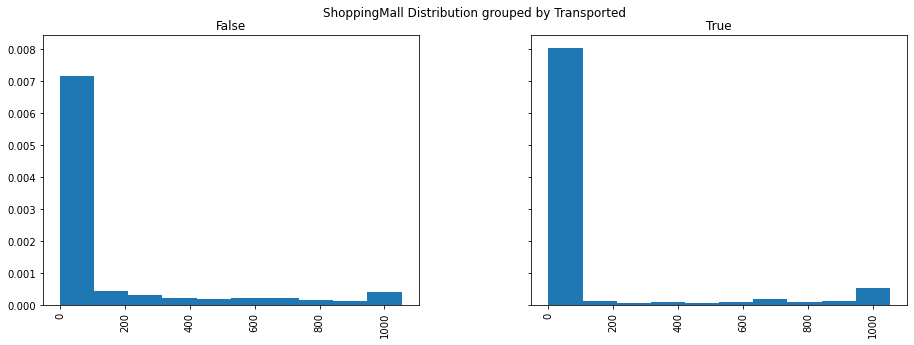

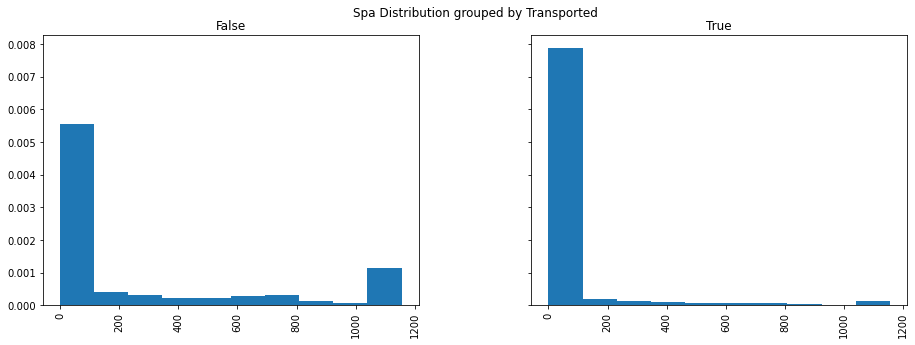

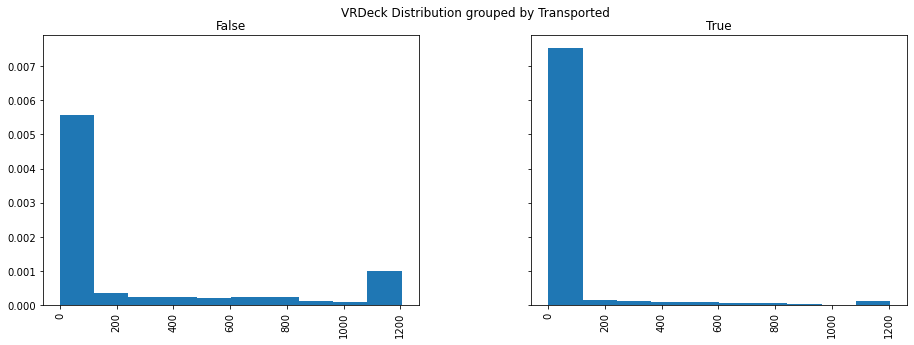

In [27]:
"""Plot the distribution of continuous columns by target column"""
distribution_plot (cont_col,train=train)

INSIGHT:
- Not a strong correlation in general, with some exceptions:
- *Age*: Below 20 more likely to be transported, 30-40 less likely ==> we can bucket "Age" in different buckets to make correlation emerge
- *RoomService* and other expenses' cols: More likely to be trasported if little or no expenditure - may be correlated with CryoSleep column

In [28]:
# We bucket age into age groups if the X-Squared test detects causality with the taerget column
train = fe_age_col (train)

In [29]:
# Scale continuous variables
scaled = copy.deepcopy(train)
scaled = scale_cont_vars (cont_col, scaled)
# QC
scaled[cont_col].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6.773000e+03,6.773000e+03,6.773000e+03,6.773000e+03,6.773000e+03,6.773000e+03
mean,5.966650e-17,-2.475422e-16,-7.009174e-17,6.268424e-16,-4.519245e-17,1.482483e-16
std,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00
min,-1.988553e+00,-4.754090e-01,-4.647739e-01,-4.559516e-01,-4.843696e-01,-4.684904e-01
25%,-6.810483e-01,-4.754090e-01,-4.647739e-01,-4.559516e-01,-4.843696e-01,-4.684904e-01
50%,-1.305199e-01,-4.754090e-01,-4.647739e-01,-4.559516e-01,-4.843696e-01,-4.684904e-01
75%,6.264567e-01,-3.123935e-01,-3.150186e-01,-3.408134e-01,-3.004156e-01,-3.261672e-01
max,3.447915e+00,3.102352e+00,3.048160e+00,3.216695e+00,2.941403e+00,3.030048e+00


In [30]:
# We encode categorical columns
cats = [c for c in cat_col if c not in ['Cabin', 'Name']] + [tgtCol]
if "Age Buckets" in scaled.columns:
    cats = cats + ["Age Buckets"]

sclEnc = copy.deepcopy(scaled)
sclEnc = encode_categorical_cols (sclEnc, cats)
sclEnc.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age Buckets
0,0001_01,1,0,B/0/P,2,0.695273,0,-0.475409,-0.464774,-0.455952,-0.484370,-0.468490,Maham Ofracculy,0,3
1,0002_01,0,0,F/0/S,2,-0.336968,0,-0.163678,-0.345691,-0.340813,1.144514,-0.340690,Juanna Vines,1,2
2,0003_01,1,0,A/0/S,2,2.002778,1,-0.312393,3.048160,-0.455952,2.941403,-0.326167,Altark Susent,0,5
3,0003_02,1,0,A/0/S,2,0.282376,0,-0.475409,1.850118,0.838481,2.941403,0.092089,Solam Susent,0,3
4,0004_01,0,0,F/1/S,2,-0.887496,0,0.391147,-0.338474,0.070893,1.191986,-0.346499,Willy Santantines,1,1


Correlation heatmap of original columns after scaling/encoding and before feature engineer:


<AxesSubplot:>

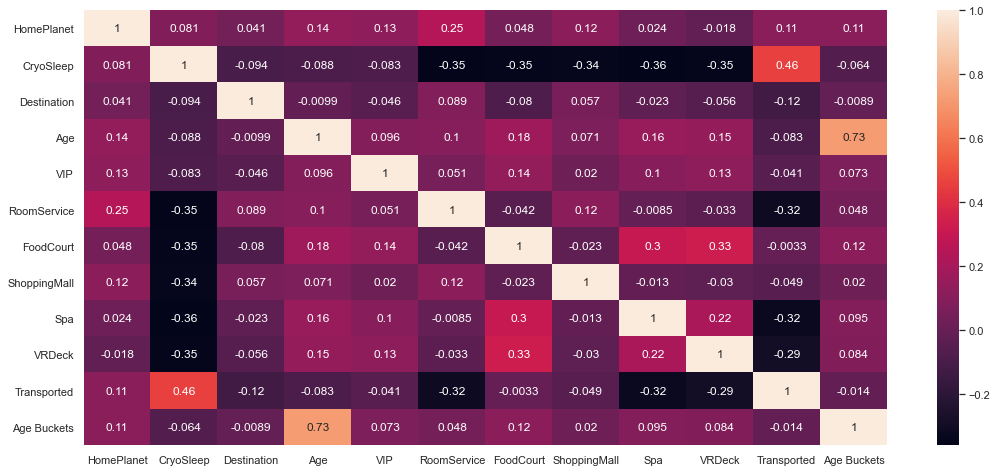

In [31]:
# Let's check the correlation between the input variables and the target column
print("Correlation heatmap of original columns after scaling/encoding and before feature engineer:")
sns.set(rc={'figure.figsize':(18,8)})
sns.heatmap(sclEnc.corr(), annot=True)

INSIGHT
- *CryoSleep*: Shows high positive correlation with the target column "Transported"
- *SPA and the other expenses-related columns*: shows high negative correlation with the target column. They might correlate negatively with cryosleep so we might not get much more predictive power using both => try group them in a common column
- *HomePlanet* and *Destination* show a mild correlation with the target column. Mind there might be overlap b/w the 2 (planet destination =! from embarked)
- *Age* and *Age Buckets*: Age surprisingly not correlated much with Target column, although we observed in the charts a different distribution depending on age buckets

# Baseline Models

In [32]:
"""
Before proceeding with feature engineer, we build a baseline model with the score to beat
For the first baseline model, we consider only the parameter that showed the highest correlation with the taeget column: CryoSleep 
"""
baseline1 = copy.deepcopy(sclEnc)
baseline1 = baseline1[['CryoSleep',tgtCol]] # np.array(baseline1['CryoSleep']).reshape(-1, 1)

# Check the score to beat
b1_pred, b1_accuracy, b1_precision, b1_recall, b1_f1, b1_score, b1_MSE = apply_model (
    model_name = "baseline1", train=baseline1, model=LogisticRegression ())


Model baseline1: accuracy = 0.754, precision = 0.770, recall = 0.754, f1 = 0.751, score = 0.714, MSE = 14884.000


# Feature Engineer

Add some feature engineer to beat the baseline model's score:
- *Expenses*: group all the disctretionary expenses into one column, get rid of the others
- *Cabin*: segment the cabin according to its Deck/Side coordinates (further analysis: group by cabin number buckets)
- *PassangerId*: split it according if part of a group or not

Correlation heatmap after feature engineer: 


<AxesSubplot:>

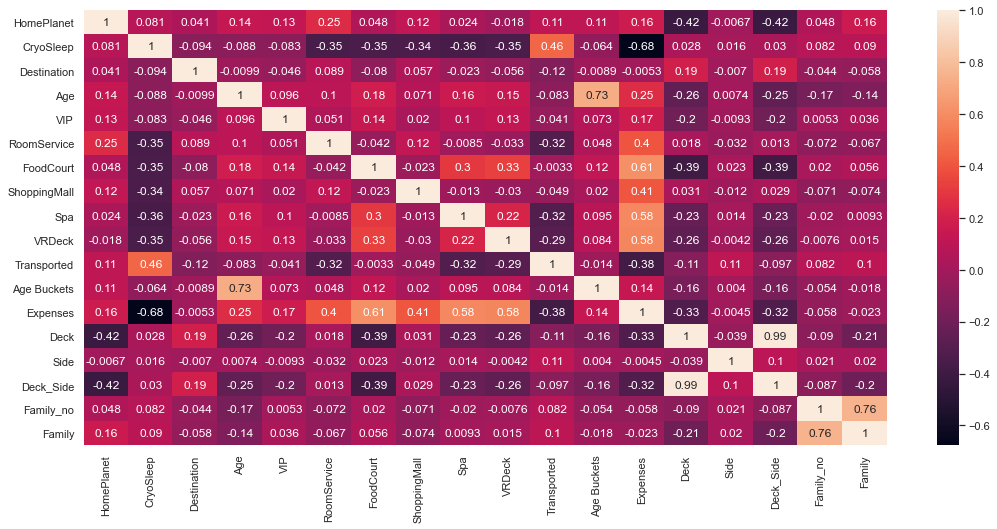

In [33]:
"""
COL ==> Expenses: 
build a discretionary expenses column"""

expenses = [c for c in cont_col if c != "Age"]

model = copy.deepcopy(sclEnc)
model = fe_expenses_col (model,expenses, delete = False)

"""
COL ==> Cabin: 
Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
let's build a different feature where we account for the rough position (deck + side) within the spacecraft
"""

model = fe_cabin_col (model)

"""
COL ==> "PassengerId":
==> Let's check if the passenger was part of a group or not.

Possible Additional Route:
We could check if the passengers belonging to the same group shared the same cabin or not, and see how this influenced survival -but probably too much
We could check for family mambers within groups using the surname, but maybe not too relevant
"""

model = family_col (df=model)

# Let's check the correlation heatmap
print("Correlation heatmap after feature engineer: ")
sns.set(rc={'figure.figsize':(18,8)})
sns.heatmap(model.corr(), annot=True)

INSIGHTS
* *Deck* and *Side* had opposite correlation and cancelled themselves in the "Deck_Side" column. => Maybe combine "Deck" with bucketed cabin number?
* *Age Buckets* has a considerably lower predicting power than *Age* alone => Try reduce the bucket size?

In [34]:
# Now let's apply the best model finder that recursively eliminates the less corrrelated columns and picks the model with the highest score
m_pred, m_accuracy, m_precision, m_recall, m_f1, m_score, m_MSE = find_best_model (df=model, ML_model=LogisticRegression() )

print("Final score: {}".format(np.round(m_score,3)))

Model ['CryoSleep', 'Expenses', 'Spa', 'RoomService', 'VRDeck', 'Destination', 'Deck', 'HomePlanet', 'Side', 'Family', 'Deck_Side', 'Age', 'Transported']: accuracy = 0.806, precision = 0.810, recall = 0.806, f1 = 0.805, score = 0.788, MSE = 3025.000
Final score: 0.788


In [35]:
# Finally, let's compare the scores differences with the baseline model

acc_diff = {"Accuracy Difference: " : np.round(m_accuracy-b1_accuracy,3),
            "Precision Difference: " : np.round(m_precision - b1_precision,3),
            "Recall Difference: ": np.round(m_recall- b1_recall,3),
            "f1 Difference: " : np.round(m_f1 - b1_f1,3),
            "Avg. score Difference: ": np.round(m_score - b1_score,3),
            "MSE Difference: ": np.round(m_MSE - b1_MSE,3)}

print ("Difference in scores b/w optimal model and baseline model (OPT - Baseline): {}". format(acc_diff))

Difference in scores b/w optimal model and baseline model (OPT - Baseline): {'Accuracy Difference: ': 0.052, 'Precision Difference: ': 0.04, 'Recall Difference: ': 0.052, 'f1 Difference: ': 0.055, 'Avg. score Difference: ': 0.073, 'MSE Difference: ': -11859.0}


# Next Steps:
- Fill more null values (different columns)
- Apply a different model instead of logistic regression